# 0. 사용할 패키지 불러오기

In [1]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling2D
from tensorflow.python.keras.layers.core import Activation
from tensorflow.python.keras.layers.core import Flatten
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.python.keras.layers.core import Dense
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.models import load_model
import cv2


# 1. 데이터 불러오기

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [2]:
import numpy as np
import glob
import sys
from sklearn.model_selection import train_test_split

x_train = np.empty((0, 180, 240, 1))
y_train = np.empty((0, 3))
print(y_train.shape)

training_data = glob.glob('/home/pirl/Documents/motion20000/*.npz')

x_train = []
for single_npz in training_data:
    with np.load(single_npz) as data:
        #print(data.files)
        x = data['train']
        y = data['trining_label']
        print(x.shape)
        
        '''for i in range(x.shape[0]):
            tmp = x[i]
            temp=cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY) # convert color to gray
            x = np.reshape(temp, ( -1, 180, 240, 1))
            
            x_train = np.vstack((x_train, x))'''
        
        temp_list = []
        for i in x:
            temp=cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
            temp_list.append(np.reshape(temp,(180, 240, 1)))
            y_train = np.vstack((y_train, y))
            
        x_train.extend(temp_list)
        
        
x_train = np.array(x_train)        

print(x_train.shape)
print(y_train.shape)
# train test split, 7:3
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state = 42)

y_train = y_train[:,:]
y_test = y_test[:,:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(0, 3)
(3044, 180, 240, 3)
(3038, 180, 240, 3)
(3013, 180, 240, 3)
(9095, 180, 240, 1)
(9095, 3)
(6366, 180, 240, 1) (6366, 3)
(2729, 180, 240, 1) (2729, 3)


# 데이터 확인

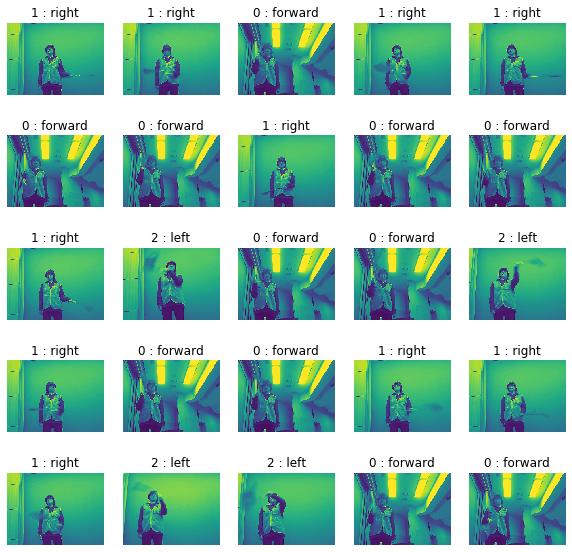

In [3]:
# 데이터 확인
from matplotlib import pyplot as plt
%matplotlib inline

plt_row = 5
plt_col = 5
plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

for i in range(plt_row*plt_col):

    sub_plt = axarr[int(i/plt_row), int(i%plt_col)]
    sub_plt.axis('off')
    sub_plt.imshow(x_train[i].reshape(180, 240))
    
    label = np.argmax(y_train[i])
                      
    if label == 2 :
        direction = 'left'
    elif label == 1:
        direction = 'right'
    elif label == 0:
        direction = 'forward'
                      
    sub_plt_title = str(label) + " : " + direction
    sub_plt.set_title(sub_plt_title)

plt.show()

# 3. 모델 생성

In [4]:
# image size = 160 x 320
def posla_net():
    
    # model setting
    H = 180
    W = 240
    CH = 1

    inputShape = (H, W, CH)

    activation = 'relu'
    keep_prob_conv = 0.25
    keep_prob_dense = 0.5

    #init = 'glorot_normal'
    #init = 'he_normal'
    init = 'he_uniform'
    chanDim = -1
    classes = 3
    
    model = Sequential()
    
    # CONV => RELU => POOL
    model.add(Conv2D(3, (3, 3), padding="valid", input_shape=inputShape, kernel_initializer=init, activation=activation))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(9, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(18, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(80, kernel_initializer=init, activation=activation))
    model.add(Dropout(keep_prob_dense))
    
    model.add(Dense(15, kernel_initializer=init, activation=activation))
    model.add(Dropout(keep_prob_dense))
    
    # softmax classifier
    model.add(Dense(classes , activation = 'softmax'))
    
    return model

In [5]:
model = posla_net()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 238, 3)       30        
_________________________________________________________________
batch_normalization (BatchNo (None, 178, 238, 3)       12        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 119, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 117, 9)        252       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 58, 9)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 56, 18)        1476      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 28, 18)        0         
__________

In [15]:
# from tensorflow.python.keras.utils import plot_model
# plot_model(model, to_file= 'video_net_plot.png', show_shapes = True, show_layer_names = True)

# 4. 모델 파라미터 셋팅

적은 수의 이미지 데이터가 존재할 경우 데이터를 늘리는 용도로 사용

In [6]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [8]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [70]:
# initialize the model
# EPOCHS = 50
# INIT_LR = 1e-3
# BS = 32
# split_ratio = 0.2

In [9]:
EPOCHS = 50
INIT_LR = 1e-4
BS = 256
split_ratio = 0.2

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
 

[INFO] compiling model...


# 5. 모델 훈련

In [76]:
from tensorflow.keras.utils import to_categorical


In [10]:
y_binary = to_categorical(y_train)

NameError: name 'to_categorical' is not defined

In [11]:
hist = model.fit(x_train, y_train, 
                 epochs=EPOCHS, batch_size=BS, 
                 validation_split=split_ratio, 
                 verbose = 1
                 ,callbacks=[reduce_lr]
                )

Train on 5092 samples, validate on 1274 samples
Epoch 1/50
5092/5092 [==============================] - 17s 3ms/step - loss: 2.8581 - acc: 0.5016 - val_loss: 0.9249 - val_acc: 0.5408
Epoch 2/50
5092/5092 [==============================] - 3s 599us/step - loss: 1.0700 - acc: 0.6785 - val_loss: 0.3959 - val_acc: 0.6962
Epoch 3/50
5092/5092 [==============================] - 3s 602us/step - loss: 0.7658 - acc: 0.7594 - val_loss: 0.2500 - val_acc: 0.9717
Epoch 4/50
5092/5092 [==============================] - 3s 600us/step - loss: 0.5913 - acc: 0.8024 - val_loss: 0.1298 - val_acc: 0.9874
Epoch 5/50
5092/5092 [==============================] - 3s 602us/step - loss: 0.4900 - acc: 0.8268 - val_loss: 0.1027 - val_acc: 0.9851
Epoch 6/50
5092/5092 [==============================] - 3s 592us/step - loss: 0.4654 - acc: 0.8460 - val_loss: 0.0744 - val_acc: 0.9874
Epoch 7/50
5092/5092 [==============================] - 3s 602us/step - loss: 0.4207 - acc: 0.8559 - val_loss: 0.0605 - val_acc: 0.9882
E

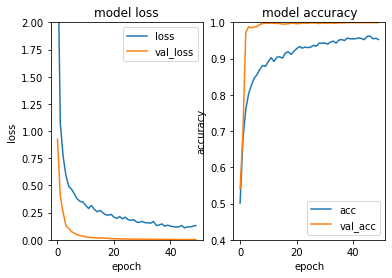

In [12]:
plt.subplot(1, 2, 1)
plt.title('model loss')
plt.plot(hist.history['loss'], label="loss")
plt.plot(hist.history['val_loss'], label="val_loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.ylim((0,2))

plt.subplot(1, 2, 2)
plt.title('model accuracy')
plt.plot(hist.history['acc'], label="acc")
plt.plot(hist.history['val_acc'], label="val_acc")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.ylim((0.4, 1))


plt.show();

# 6. 모델 결과 확인

In [25]:
#l_model = load_model('./model_data/VGG_model.h5')

In [13]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=BS)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

2729/2729 [==============================] - 1s 409us/step
## evaluation loss and_metrics ##
[0.0012896792718201477, 1.0]


In [14]:
xhat_idx = np.random.choice(x_test.shape[0], 10)
xhat = x_test[xhat_idx]

yhat_classes = model.predict_classes(xhat)

for i in range(10):
    print('True : ' + str(np.argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat_classes[i]))

True : 2, Predict : 2
True : 1, Predict : 1
True : 0, Predict : 0
True : 0, Predict : 0
True : 1, Predict : 1
True : 1, Predict : 1
True : 1, Predict : 1
True : 0, Predict : 0
True : 0, Predict : 0
True : 2, Predict : 2


# 7. 최종 모델 훈련

In [15]:
x_total = np.vstack((x_train, x_test))
y_total = np.vstack((y_train, y_test))

print(x_total.shape)
print(y_total.shape)

(9095, 180, 240, 1)
(9095, 3)


In [16]:
early_stopping = EarlyStopping(monitor='loss', patience=10)

In [17]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [20]:
EPOCHS = 50
INIT_LR = 1e-4
BS = 256
split_ratio = 0.2

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


In [21]:
hist = model.fit(x_total, y_total, 
                 epochs=EPOCHS, batch_size=BS, 
                 #validation_split=split_ratio, 
                 verbose = 1
                 ,callbacks=[reduce_lr]
                )

Epoch 1/50
9095/9095 [==============================] - 6s 612us/step - loss: 0.1053 - acc: 0.9629
Epoch 2/50
9095/9095 [==============================] - 5s 510us/step - loss: 0.1071 - acc: 0.9631
Epoch 3/50
9095/9095 [==============================] - 5s 522us/step - loss: 0.0913 - acc: 0.9680
Epoch 4/50
9095/9095 [==============================] - 5s 519us/step - loss: 0.0880 - acc: 0.9660
Epoch 5/50
9095/9095 [==============================] - 5s 513us/step - loss: 0.0860 - acc: 0.9724
Epoch 6/50
9095/9095 [==============================] - 5s 520us/step - loss: 0.0884 - acc: 0.9690
Epoch 7/50
9095/9095 [==============================] - 5s 513us/step - loss: 0.0846 - acc: 0.9698
Epoch 8/50
9095/9095 [==============================] - 5s 522us/step - loss: 0.0791 - acc: 0.9691
Epoch 9/50
9095/9095 [==============================] - 5s 521us/step - loss: 0.0791 - acc: 0.9711
Epoch 10/50
9095/9095 [==============================] - 5s 517us/step - loss: 0.0753 - acc: 0.9704
Epoch 11/

In [22]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=BS)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

2729/2729 [==============================] - 1s 424us/step
## evaluation loss and_metrics ##
[2.274601310630949e-06, 1.0]


In [23]:
xhat_idx = np.random.choice(x_test.shape[0], 10)
xhat = x_test[xhat_idx]

yhat_classes = model.predict_classes(xhat)

for i in range(10):
    print('True : ' + str(np.argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat_classes[i]))

True : 1, Predict : 1
True : 1, Predict : 1
True : 1, Predict : 1
True : 1, Predict : 1
True : 0, Predict : 0
True : 2, Predict : 2
True : 1, Predict : 1
True : 0, Predict : 0
True : 1, Predict : 1
True : 1, Predict : 1


# 8. 모델 저장

In [35]:
#model.save('./model_data/video_model_3.h5')

In [24]:
from tensorflow.python.keras.models import model_from_yaml

model_yaml = model.to_yaml()
with open("mm_v1.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("mm_v1.h5")
print("Saved model to disk")

Saved model to disk
